In [180]:
from datetime import datetime
from operator import index

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sktime.forecasting.base
import tensorflow as tf
import holidays
import pywt
import keras
from statsmodels.graphics.tsaplots import plot_acf
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer

# Prep Work

In [142]:
def load_and_concat_data(file_paths, column_names) -> pd.DataFrame:
    """
    Load and concatenate data from multiple CSV files given by file_paths.

    :param file_paths: List of file paths to the CSV files.
    :param column_names: List of column names for the CSV files.

    :returns: pd.DataFrame: DataFrame for each feature containing raw data from the years 2023 - 2024.
    """
    df = [pd.read_csv(file_path, header=1, names=column_names) for file_path in file_paths]
    concat_data = pd.concat(df)
    concat_data.reset_index(drop=True, inplace=True)
    concat_data["timestamp"] = pd.to_datetime(concat_data["timestamp"])
    concat_data.set_index("timestamp", inplace=True)
    
    # if na values are present interpolate them based on the timestamp
    if concat_data.isna().sum().sum() > 0:
        concat_data.interpolate(method="time", inplace=True)
    
    return concat_data

### File Paths and Column Names config

In [4]:
file_paths = {
    "de_prices": ["../data/raw/de_prices_2023.csv", "../data/raw/de_prices_2024.csv"],
    "de_load": ["../data/raw/de_load_2023.csv", "../data/raw/de_load_2024.csv"],
    "de_solar_gen": ["../data/raw/de_solar_gen_2023.csv", "../data/raw/de_solar_gen_2024.csv"],
    "de_wind_gen_offshore": ["../data/raw/de_wind_gen_offshore_2023.csv", "../data/raw/de_wind_gen_offshore_2024.csv"],
    "de_wind_gen_onshore": ["../data/raw/de_wind_gen_onshore_2023.csv", "../data/raw/de_wind_gen_onshore_2024.csv"],
    "ch_load": ["../data/raw/ch_load_2023.csv", "../data/raw/ch_load_2024.csv"],
    "dk_load": ["../data/raw/dk_load_2023.csv", "../data/raw/dk_load_2024.csv"],
    "fr_load": ["../data/raw/fr_load_2023.csv", "../data/raw/fr_load_2024.csv"]
}

column_names = {
    "de_prices": ["timestamp", "de_lu_price"],
    "de_load": ["timestamp", "de_load"],
    "de_solar_gen": ["timestamp", "de_solar_gen"],
    "de_wind_gen_offshore": ["timestamp", "de_wind_gen_offshore"],
    "de_wind_gen_onshore": ["timestamp", "de_wind_gen_onshore"],
    "ch_load": ["timestamp", "ch_load"],
    "dk_load": ["timestamp", "dk_load"],
    "fr_load": ["timestamp", "fr_load"]
}

### Populate new dataframes with raw data from years 2023 and 2024

In [5]:
de_prices = load_and_concat_data(file_paths["de_prices"], column_names["de_prices"])
de_load = load_and_concat_data(file_paths["de_load"], column_names["de_load"])
de_solar_gen = load_and_concat_data(file_paths["de_solar_gen"], column_names["de_solar_gen"])
de_wind_gen_offshore = load_and_concat_data(file_paths["de_wind_gen_offshore"], column_names["de_wind_gen_offshore"])
de_wind_gen_onshore = load_and_concat_data(file_paths["de_wind_gen_onshore"], column_names["de_wind_gen_onshore"])
ch_load = load_and_concat_data(file_paths["ch_load"], column_names["ch_load"])
dk_load = load_and_concat_data(file_paths["dk_load"], column_names["dk_load"])
fr_load = load_and_concat_data(file_paths["fr_load"], column_names["fr_load"])

In [6]:
# sub-sampling the quarter hourly timeseries to hourly. see readme for affected timeseries
de_load = de_load[::4]
de_solar_gen = de_solar_gen[::4]
de_wind_gen_offshore = de_wind_gen_offshore[::4]
de_wind_gen_onshore = de_wind_gen_onshore[::4]

In [211]:
dataframes = [
    de_prices,
    de_load,
    de_solar_gen,
    de_wind_gen_offshore,
    de_wind_gen_onshore,
    ch_load,
    dk_load,
    fr_load
]

combined_df = pd.concat(dataframes, axis=1)

In [38]:
# save dataset to csv in ../data/interim
combined_df.to_csv("../data/interim/combined_data.csv")

# Statisical Analysis

In [79]:
# statistical overview
combined_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
de_lu_price,17544.0,87.364521,57.217911,-500.0,62.8675,88.85,112.500,2325.83
de_load,17544.0,52696.795389,9124.620901,28030.9,45180.1750,52714.90,59755.875,75364.20
de_solar_gen,17544.0,6774.497418,10467.715337,0.8,3.4000,110.10,10672.025,46994.80
de_wind_gen_offshore,17544.0,2801.950838,1861.232107,0.0,1127.7500,2609.55,4326.275,7634.80
de_wind_gen_onshore,17544.0,13175.531766,10290.344627,43.4,4917.2500,10348.15,19263.225,47965.40
ch_load,17544.0,6879.845651,1053.874647,2742.6,6185.0500,6898.40,7588.725,10437.10
dk_load,17544.0,4061.867909,718.324942,2371.2,3526.4750,4047.25,4587.725,9069.60
fr_load,17544.0,48756.730392,9949.586147,28744.0,41534.5000,47265.00,54975.500,82800.00


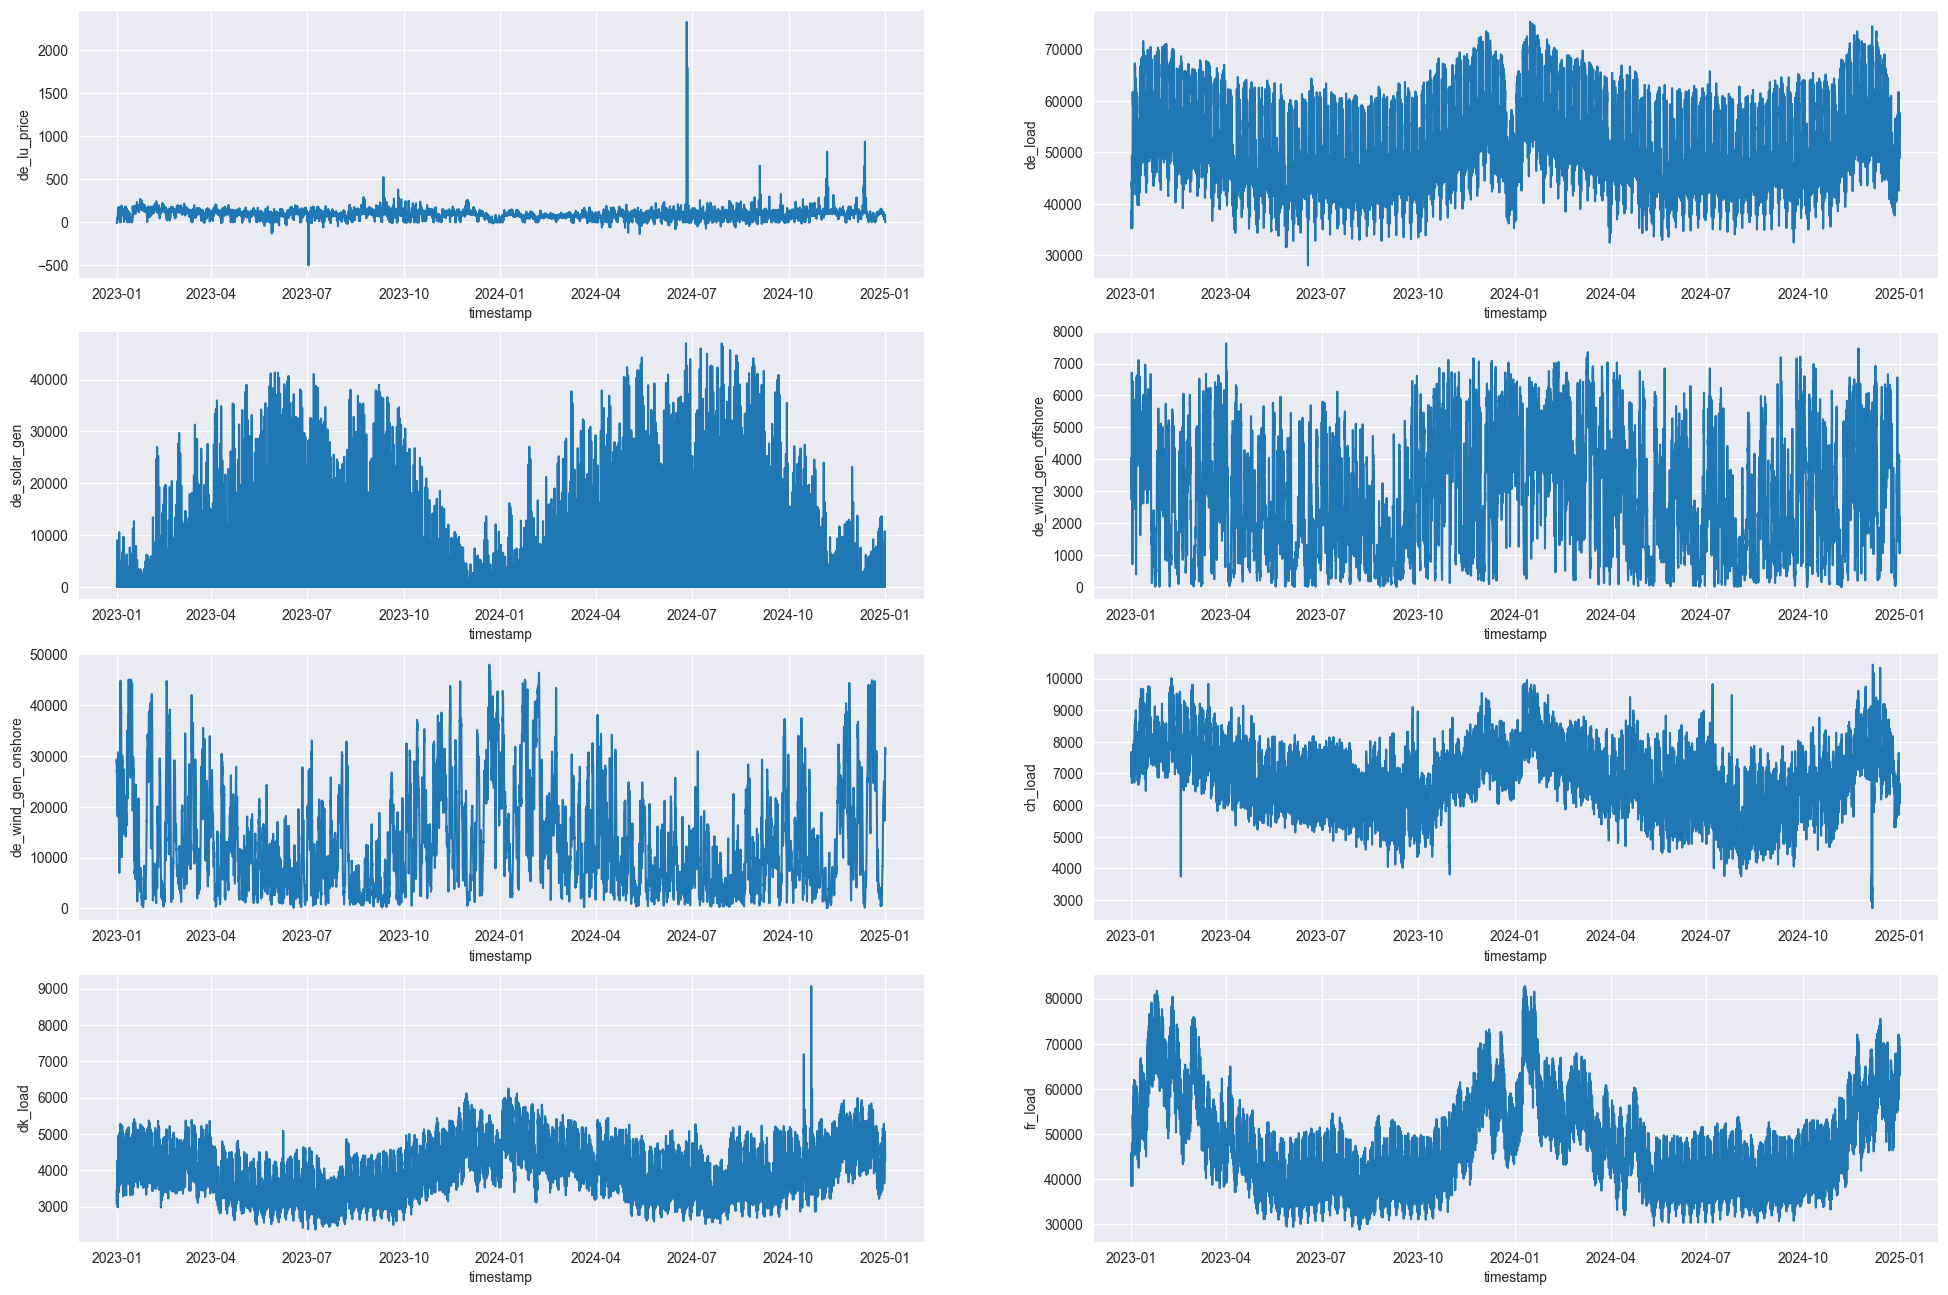

In [40]:
# plot all timeseries for visual inspection
plt.figure(figsize=(24, 16))

for _ in combined_df.columns:
    plt.subplot(4, 2, list(combined_df.columns).index(_)+1)
    sns.lineplot(data=combined_df[_])
    
plt.savefig("../reports/figures/plot_overview.png", dpi=300)

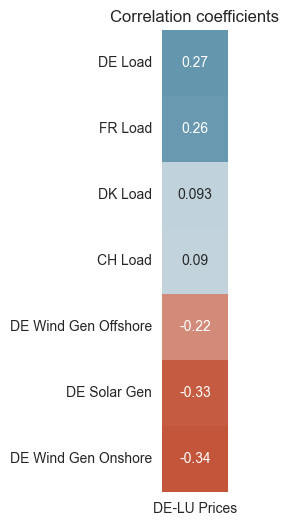

In [41]:
 # get pearson correlation coefficients and plot them
correlation_matrix = combined_df.corr(method="pearson")
correlation_matrix = correlation_matrix.drop(index=["de_lu_price"])
correlation_matrix = correlation_matrix[["de_lu_price"]].sort_values(by="de_lu_price", ascending=False)

cmap = sns.diverging_palette(20, 230, as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            cmap=cmap,
            annot=True,  
            square=True, 
            cbar=False,
            center=0,
            yticklabels=["DE Load", "FR Load", "DK Load", "CH Load", "DE Wind Gen Offshore", "DE Solar Gen", "DE Wind Gen Onshore"],
            xticklabels=["DE-LU Prices"]).set_title("Correlation coefficients")

plt.savefig("../reports/figures/de_lu_price_correlations.png", dpi=300)

plt.show()

### fft and autocorrelation are not suitable because given timeseries is non-stationary

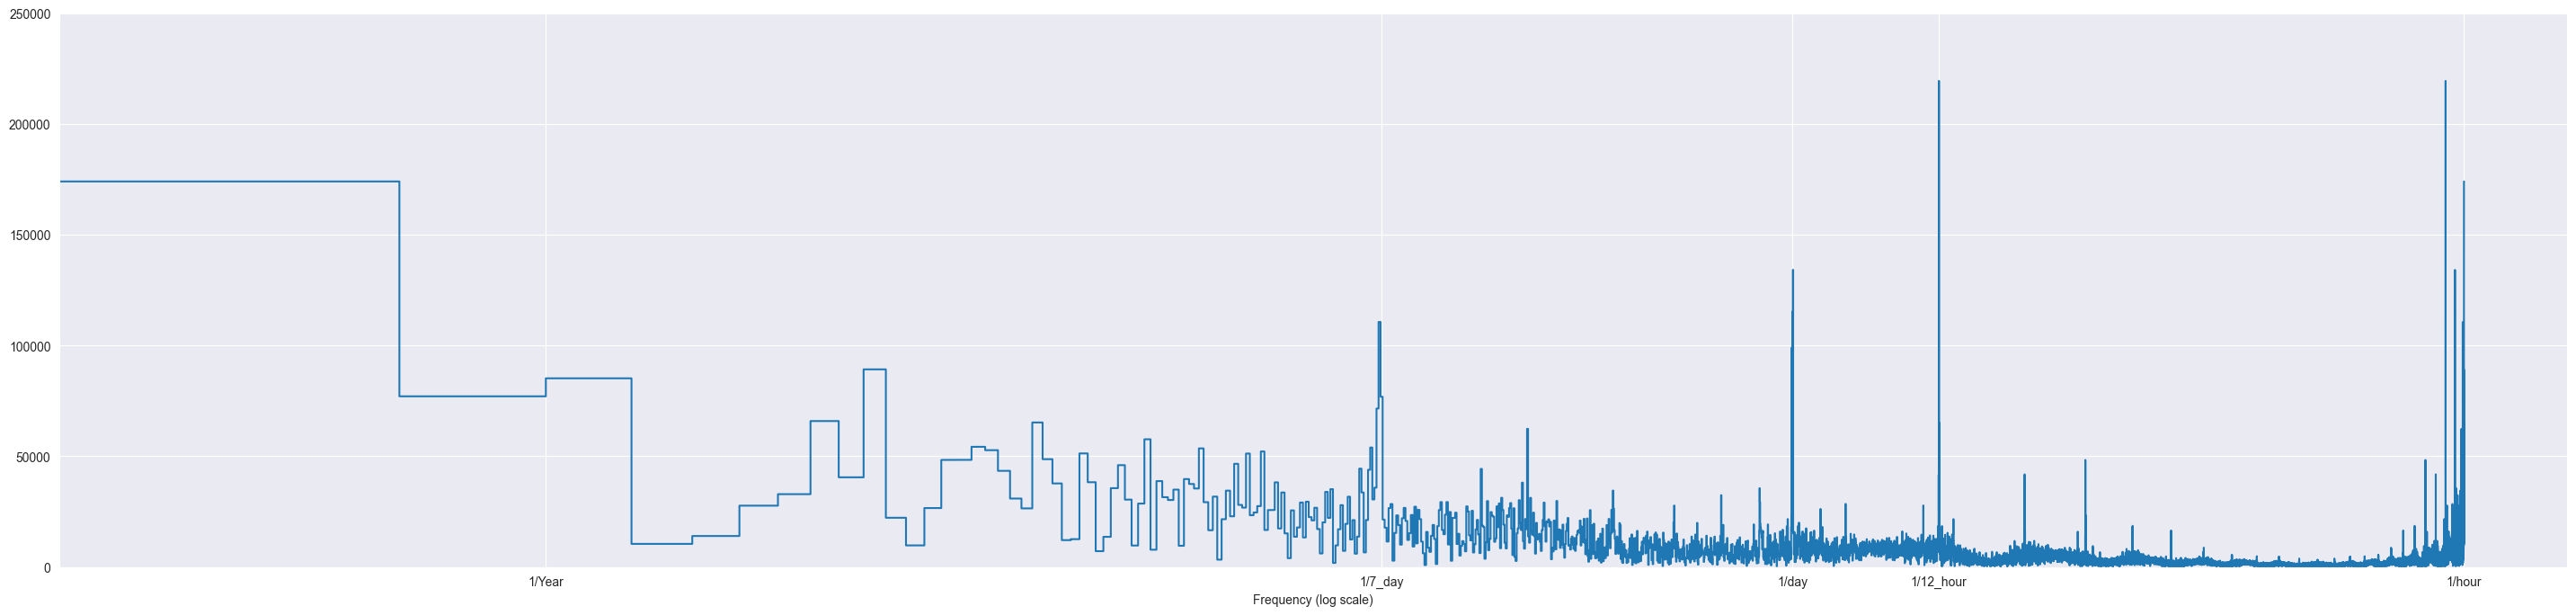

In [15]:
# to check which frequencies are present in the timeseries data fft is used
fft = tf.signal.fft(combined_df["de_lu_price"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(combined_df["de_lu_price"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / hours_per_year

plt.figure(figsize=(36, 8))
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 250000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/7, 365.2524, 365.2524*2, 365.2524*24], labels=['1/Year', '1/7_day', '1/day', '1/12_hour', '1/hour'])
_ = plt.xlabel('Frequency (log scale)')

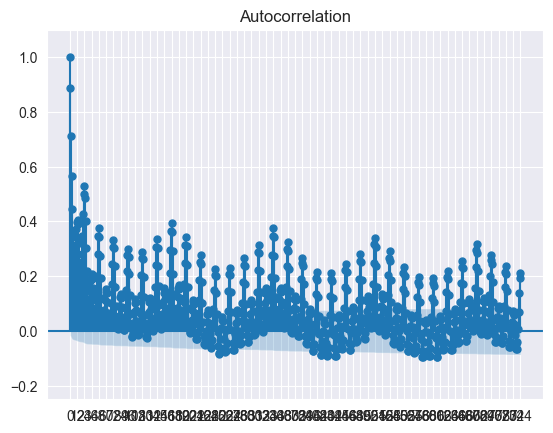

In [12]:
# to further validate time frequencies autocorrelation is measured
plot_acf(combined_df["de_lu_price"], lags=31*24)
plt.ylim(-0.25, 1.1)
plt.xticks(np.arange(0, 31*24+1, 12))
plt.show()

# Feature Engineering

In [212]:
# create calendar features
combined_df["month"] = pd.DatetimeIndex(combined_df.index).month
# 1 = Monday, 7 = Sunday, add 1 because default is 0 = Monday
combined_df["day_of_week"] = pd.DatetimeIndex(combined_df.index).day
# uses holiday library see references/refs.md [4]
de_holidays = holidays.country_holidays("DE", years=[2023,2024])
# set holiday to 1 if it is a holiday else 0
combined_df["holiday"] = combined_df.index.to_series().apply(lambda x: 1 if x in de_holidays else 0)

In [252]:
# remove outliers from features using Hampel Filter
def detect_and_remove_outliers(feature, window_length, n_sigma, imputer_method: str = None) -> pd.DataFrame:
    """
    Detect and remove outliers from features using Hampel Filter. Only imputes where outliers are present.
    
    :param feature: The feature where outliers should be removed.
    :param window_length: Window length for Hampel Filter.
    :param n_sigma: Number of standard deviations for outlier detection.
    :param imputer_method: Method for imputing missing values.
    
    :returns: DataFrame containing all features with outliers removed where applicable.
    """
    hampel = HampelFilter(window_length=window_length, n_sigma=n_sigma)
    imputer = Imputer(method=imputer_method) if imputer_method is not None else Imputer()
 
    feature_hat = hampel.fit_transform(feature)
    feature_imputed = imputer.fit_transform(feature_hat)
        
    return feature_imputed

In [269]:
# use nearest imputation for missing values to more or less preserve the shape of the timeseries
combined_df["de_lu_price_hat"] = detect_and_remove_outliers(combined_df["de_lu_price"], 24*1, 3, "nearest")

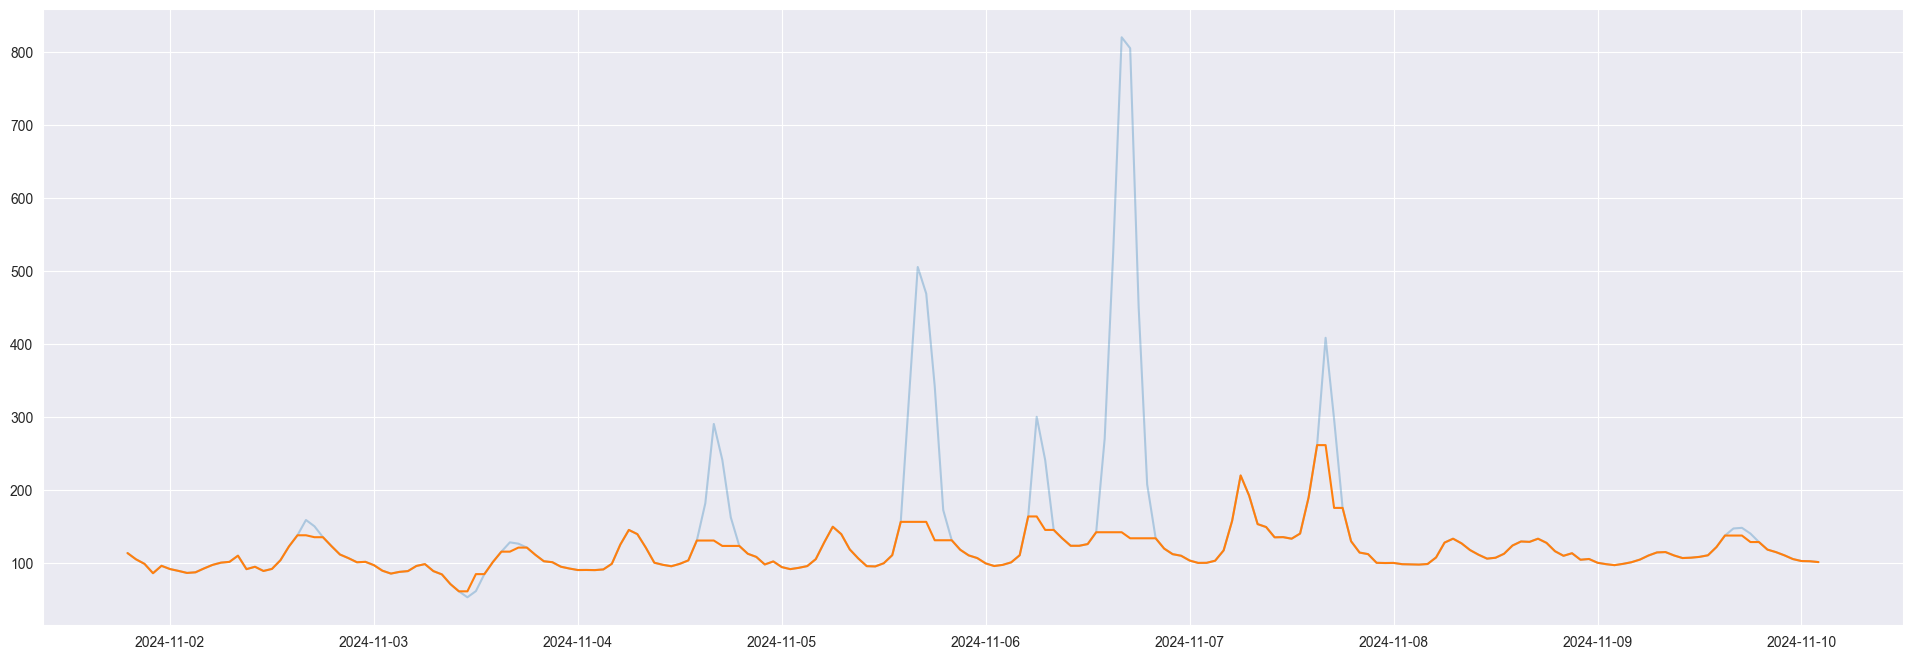

In [270]:
# example
plt.figure(figsize=(24, 8))
plt.plot(combined_df["de_lu_price"][16100:16300], label="de_lu_price", alpha=0.3)
plt.plot(combined_df["de_lu_price_hat"][16100:16300], label="de_lu_price_hat")

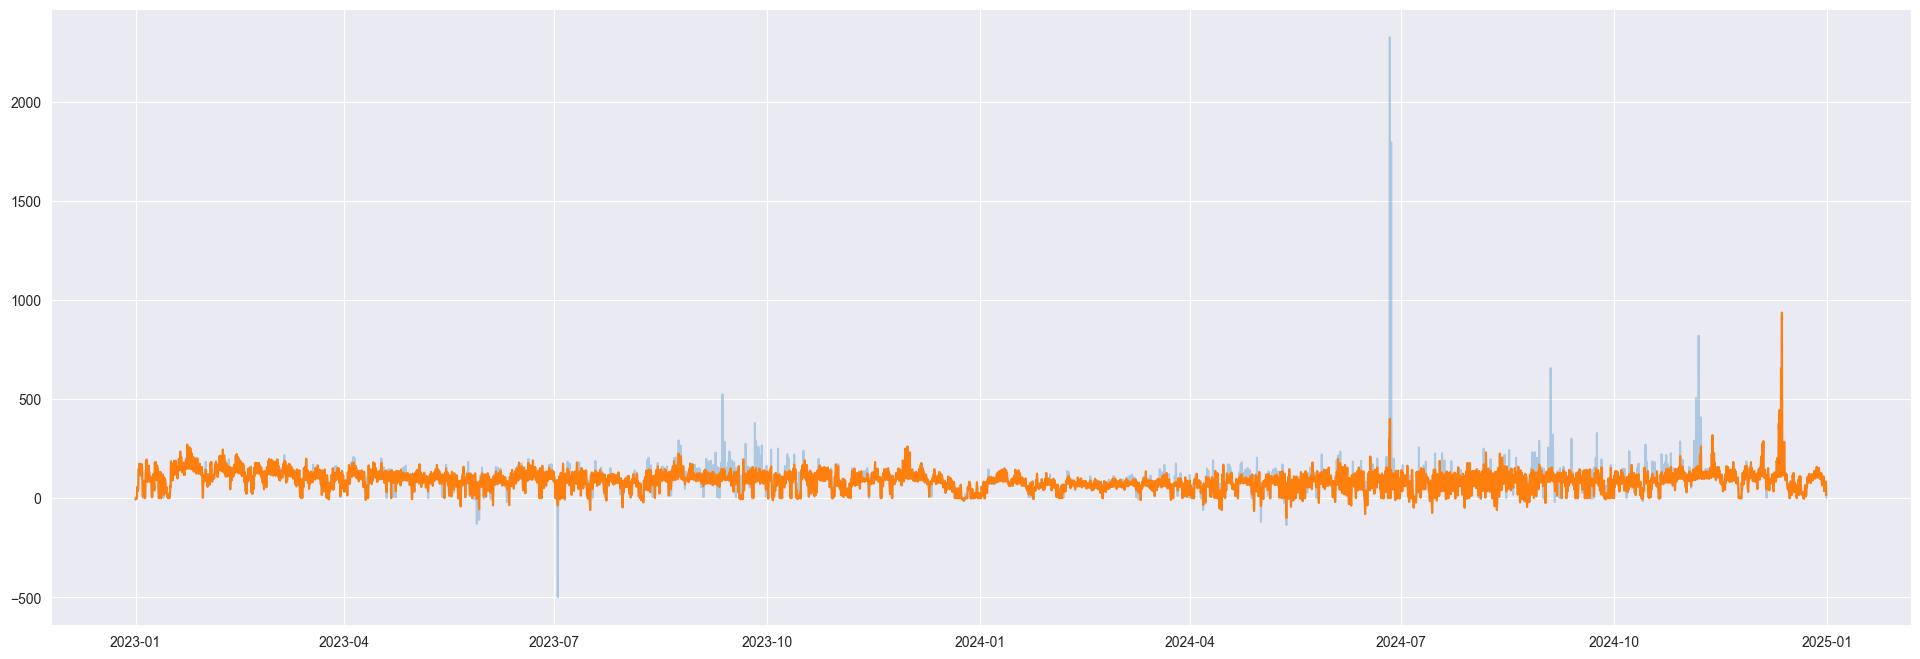

In [271]:
# example whole series
plt.figure(figsize=(24, 8))
plt.plot(combined_df["de_lu_price"], label="de_lu_price", alpha=0.3)
plt.plot(combined_df["de_lu_price_hat"], label="de_lu_price_hat")

In [272]:
# create lagged prices according to fft analysis based off of cleaned price data de_lu_price_hat
# 7 day, 1 day, 12 hour and 1 hour lags are introduced
combined_df["de_lu_price_7_day_lag"] = combined_df["de_lu_price_hat"].shift(7 * 24, fill_value=0)
combined_df["de_lu_price_1_day_lag"] = combined_df["de_lu_price_hat"].shift(24, fill_value=0)
combined_df["de_lu_price_12_hour_lag"] = combined_df["de_lu_price_hat"].shift(12, fill_value=0)
combined_df["de_lu_price_1_hour_lag"] = combined_df["de_lu_price_hat"].shift(1, fill_value=0)

In [282]:
features = combined_df.get(
    [
        'de_lu_price_hat',
        'de_load',
        'de_solar_gen',
        'de_wind_gen_offshore',
        'de_wind_gen_onshore'
     ])

dummies = combined_df.get(
    [
        'month',
        'day_of_week',
        'holiday',
    ])

feature_set = pd.concat([features, dummies], axis=1)

# Model Prep

In [283]:
# train validation test splits 70, 20, 10
column_indices = {name: i for i, name in enumerate(feature_set.columns)}

n = len(feature_set)
train_df = feature_set[0:int(n*0.7)]
validation_df = feature_set[int(n*0.7):int(n*0.9)]
test_df = feature_set[int(n*0.9):]

num_features = feature_set.shape[1]

In [284]:
# normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (validation_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\valen\AppData\Local\Temp\ipykernel_16132\459903182.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(feature_set.keys(), rotation=90)


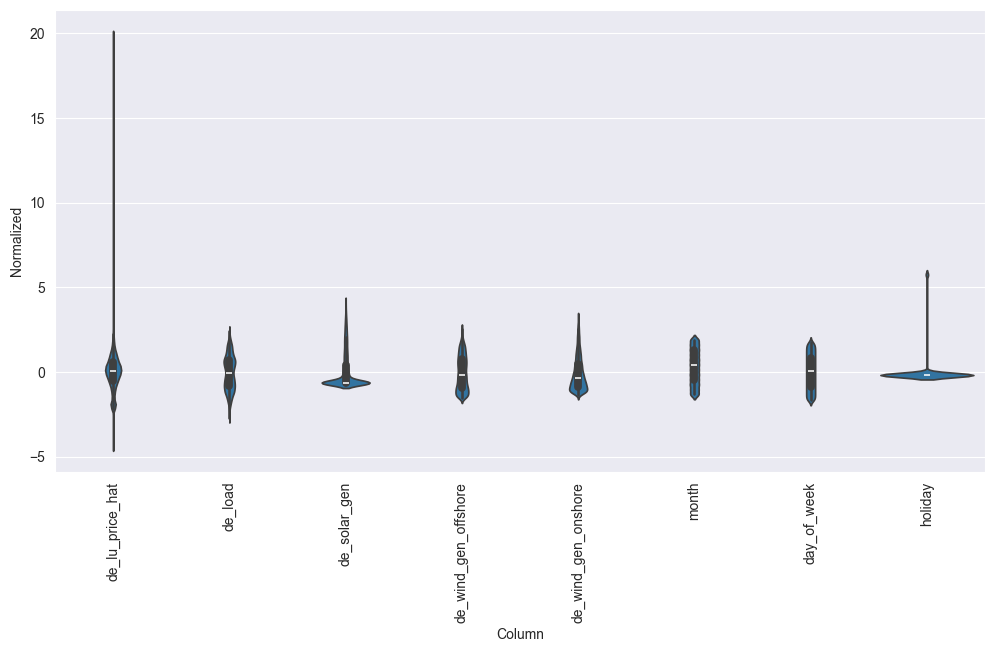

In [286]:
# plot normalized data distribution
df_std = (feature_set - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(feature_set.keys(), rotation=90)


In [340]:
# code taken from [3] /references/refs.md
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, validation_df=validation_df, test_df=test_df, 
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.validation_df = validation_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
    
      return inputs, labels
    
    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
    
      ds = ds.map(self.split_window)
    
      return ds
    
    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.validation_df)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df)
    
    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result
    
    def plot(self, model=None, plot_col="de_lu_price_hat", max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
    
        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index
    
        if label_col_index is None:
          continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
        if n == 0:
          plt.legend()
    
      plt.xlabel('Time [h]')


In [299]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Multi Step, Single Shot Models

In [347]:
OUT_STEPS = 24
window = WindowGenerator(
    input_width=24, 
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=["de_lu_price_hat"])

### LSTM

In [348]:
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [349]:
history_lstm = compile_and_fit(lstm_model, window)

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7299 - mean_absolute_error: 0.6346 - val_loss: 7567.6978 - val_mean_absolute_error: 76.1352
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5136 - mean_absolute_error: 0.5354 - val_loss: 7581.2739 - val_mean_absolute_error: 76.2218
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4168 - mean_absolute_error: 0.4831 - val_loss: 7560.2168 - val_mean_absolute_error: 76.1037
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3427 - mean_absolute_error: 0.4361 - val_loss: 7564.7505 - val_mean_absolute_error: 76.1316
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3027 - mean_absolute_error: 0.4105 - val_loss: 7583.1006 - val_mean_absolute_error: 76.2365


### GRU

In [350]:
gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [351]:
history_gru = compile_and_fit(gru_model, window)

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7166 - mean_absolute_error: 0.6297 - val_loss: 7605.9092 - val_mean_absolute_error: 76.3676
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5145 - mean_absolute_error: 0.5293 - val_loss: 7627.9009 - val_mean_absolute_error: 76.4973
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4328 - mean_absolute_error: 0.4838 - val_loss: 7600.7534 - val_mean_absolute_error: 76.3410
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3707 - mean_absolute_error: 0.4458 - val_loss: 7588.9585 - val_mean_absolute_error: 76.2733
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3404 - mean_absolute_error: 0.4258 - val_loss: 7550.0020 - val_mean_absolute_error: 76.0523
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3191 - mean_absolute_error: 0.4124 - val_loss: 7516.2271 - val_mean_absolute_error: 75.8634
Epoch 7/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2996 - mean_ab

### CNN

In [352]:
CONV_WIDTH = 3

conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [353]:
history_cnn = compile_and_fit(conv_model, window)

Epoch 1/20

383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6488 - mean_absolute_error: 0.5969 - val_loss: 111568728.0000 - val_mean_absolute_error: 7940.5444
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4664 - mean_absolute_error: 0.4970 - val_loss: 137594960.0000 - val_mean_absolute_error: 8886.8867
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4387 - mean_absolute_error: 0.4838 - val_loss: 161283680.0000 - val_mean_absolute_error: 9740.4014


## Model Evaluation

In [362]:
# compare model metrics
history_lstm_df = pd.DataFrame(history_lstm.history)
history_lstm_df

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,0.620213,0.585024,7567.697754,76.135185
1,0.481577,0.517453,7581.273926,76.221764
2,0.391198,0.466074,7560.216797,76.103691
3,0.328835,0.426506,7564.750488,76.131561
4,0.291923,0.402460,7583.100586,76.236458


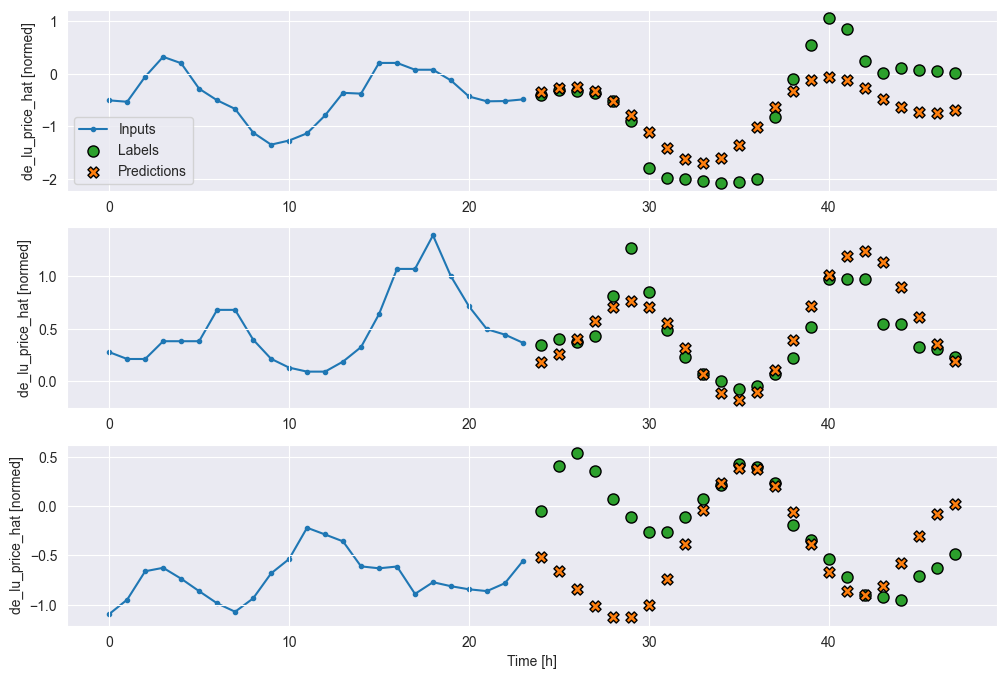

In [354]:
window.plot(lstm_model, "de_lu_price_hat")

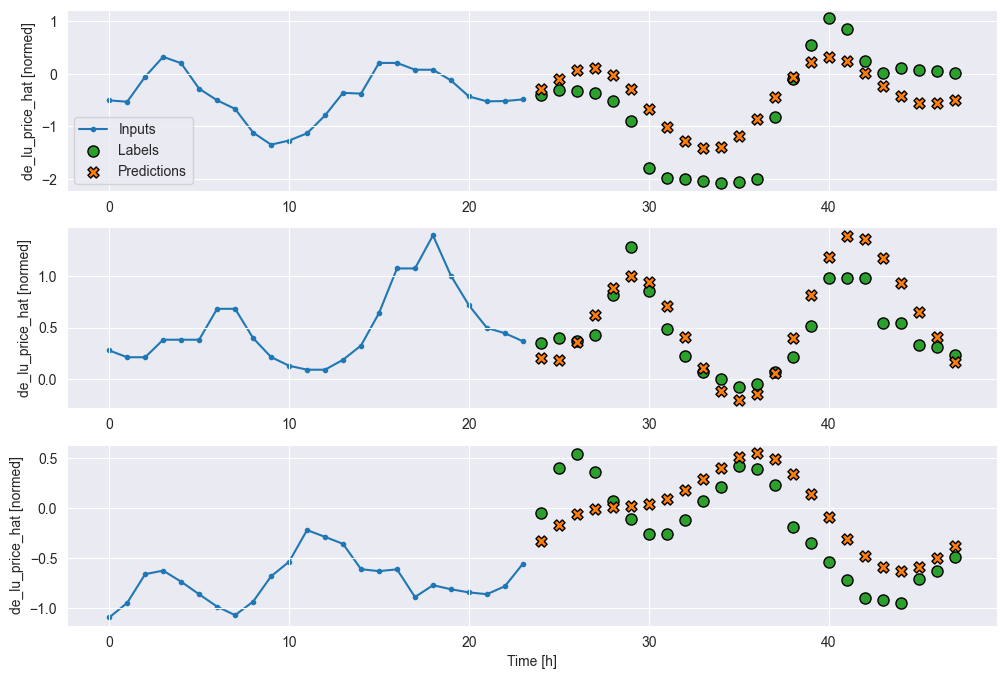

In [355]:
window.plot(gru_model, "de_lu_price_hat")

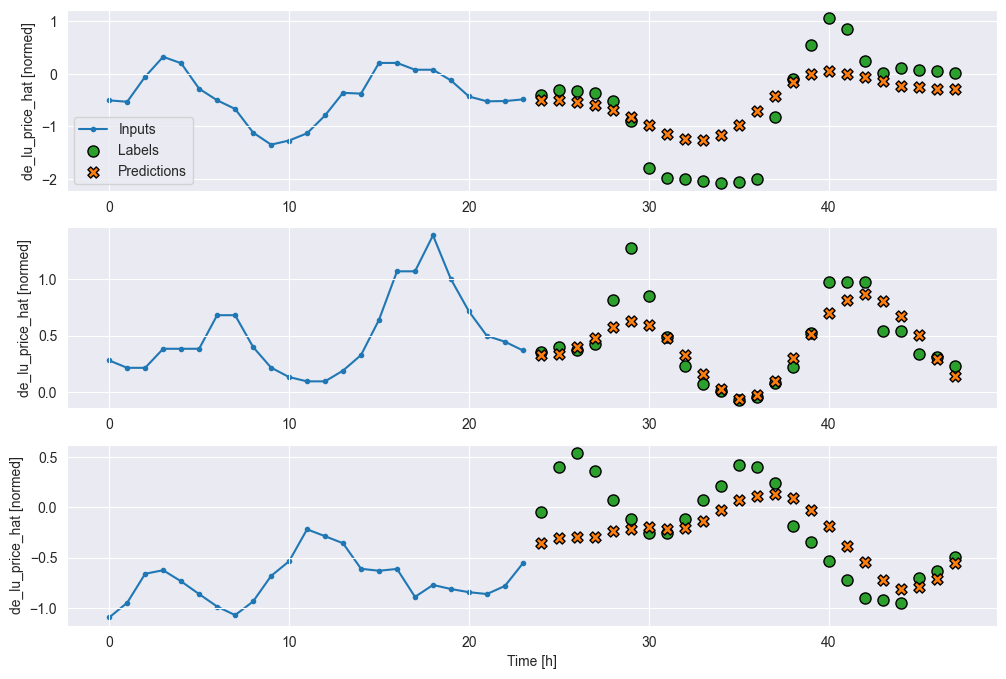

In [356]:
window.plot(conv_model, "de_lu_price_hat")

# continue here https://www.tensorflow.org/tutorials/keras/keras_tuner